Kiran Dsouza
Final Project 
Scores:
Cutoff 1   0.71415
Cutoff 2   0.81883
Cutoff 3   0.83650
Cutoff 4   0.81663
Multiclass 0.54500

In [1]:
# Basic imports, load test and training data 

import numpy as np
import matplotlib.pyplot as plt
import sys
%matplotlib inline
import pandas as pd

# Load test and training data 

dftrain = pd.read_csv("Training.csv", header = 0, encoding='utf-8')
dftest = pd.read_csv("Test.csv", header=0, encoding='utf-8')

# put the original column names in a python list
print("headers = ", dftrain.columns.values)

headers =  ['overall' 'verified' 'reviewTime' 'reviewerID' 'asin' 'reviewerName'
 'reviewText' 'summary' 'unixReviewTime' 'vote' 'image' 'style' 'category']


A big part of the project was to clean up the data and encode in numerical format.  I also did not use some of the features because my experiments showed the results were worse if I included them.  

In [2]:
# Data cleanup
# Assign encoding to non-numeric features we want to use other than reviewText and summary
# Fill in missing values
# Re-encode image and style as booleans

from sklearn import preprocessing

# get combined training/test data for encoding
dfc = pd.concat([dftrain.drop('overall', axis='columns'), dftest])

# set up encoders
enc_rid = preprocessing.LabelEncoder().fit(dfc['reviewerID'])
enc_cat = preprocessing.LabelEncoder().fit(dfc['category'])
enc_asin = preprocessing.LabelEncoder().fit(dfc['asin'])
enc_verif = preprocessing.LabelEncoder().fit(dfc['verified'])
enc_rn = preprocessing.LabelEncoder().fit(dfc['reviewerName'])

def basicDataCleanup(df):
    # Assign numeric values to nonnumeric data
    df['reviewerID'] = enc_rid.transform(df['reviewerID'])
    df['category'] = enc_cat.transform(df['category'])
    df['asin'] = enc_asin.transform(df['asin'])
    df['verified'] = enc_verif.transform(df['verified'])
    df['reviewerName'] = enc_rn.transform(df['reviewerName'])
    # Votes has missing values there are no votes. Set missing votes to 0
    df['vote'] = df['vote'].fillna(0)
    # for image, use 0-1 encoding - we only want to know if there is an image (1) or not (0)
    df['image'] = np.where(df['image'].isnull(),0,1)
    df['style'] = np.where(df['style'].isnull(),0,1)
    df['summary'] = df['summary'].fillna('')
    df['reviewText'] = df['reviewText'].fillna('')
    

# do basic data cleanup for training set and test set
basicDataCleanup(dftrain) 
basicDataCleanup(dftest)


I used the TfidfVectorizer to handle the text in the review summary and the review text. I used a 300 word limit for summary and a 1200 word limit for review text. I also limited myself to alphabetic words (no digits). 

In [3]:
# vectorize the review summary and the review text for the training data

# import the vectorizers needed for the summary and the the review
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

# cvec1 = CountVectorizer(max_features=7500,strip_accents='unicode', stop_words='english')
# cvec1 = HashingVectorizer(n_features=2**4, strip_accents='unicode', stop_words='english')
cvec1 = TfidfVectorizer(max_features=300, token_pattern=u'(?u)\\b[a-zA-Z\\.][a-zA-Z\\.]+\\b')

# Include train and test vocabulary so we don't miss important words when vectorizing
smtrain = dftrain['summary'].to_list()
smtest  = dftest['summary'].to_list()
cvec1.fit(smtrain + smtest)



# Sanity checks : look at some of the vocabulatry and the transformed summary training data
print('Vocabulary for summary')
print(cvec1.get_feature_names_out())

# vectorize the review text with same limit of 500 words
# cvec2 = CountVectorizer(max_features=10000,strip_accents='unicode', stop_words='english')
# cvec2 = HashingVectorizer(n_features=2**4, strip_accents='unicode', stop_words='english')
cvec2 = TfidfVectorizer(max_features=1200, token_pattern=u'(?u)\\b[a-zA-Z\\.][a-zA-Z\\.]+\\b')

# Include train and test vocabulary so we don't miss important words
# and map raw data to strings to avoid non-string data causing an error
rttrain = dftrain['reviewText'].to_list()
rttest  = dftest['reviewText'].to_list()
cvec2.fit(rttrain + rttest)

# Sanity checks : look at some of the vocabulatry and the transformed summary training data
print('Vocabulary for review text')
print(cvec2.get_feature_names_out())

Vocabulary for summary
['about' 'advertised' 'after' 'again' 'album' 'all' 'am' 'amazing'
 'amazon' 'an' 'and' 'another' 'any' 'are' 'as' 'at' 'awesome' 'awful'
 'back' 'bad' 'bag' 'band' 'battery' 'be' 'beautiful' 'because' 'been'
 'before' 'best' 'better' 'beware' 'big' 'bit' 'bought' 'box' 'bright'
 'broke' 'but' 'buy' 'by' 'came' 'can' 'car' 'case' 'cd' 'charger' 'cheap'
 'classic' 'coffee' 'color' 'cool' 'could' 'cover' 'cute' 'day' 'decent'
 'delicious' 'design' 'did' 'didn' 'different' 'disappointed'
 'disappointing' 'disappointment' 'do' 'does' 'doesn' 'don' 'dont' 'down'
 'durable' 'easily' 'easy' 'enough' 'even' 'ever' 'excellent' 'expected'
 'expensive' 'fan' 'far' 'fast' 'favorite' 'feel' 'few' 'fine' 'first'
 'fit' 'fits' 'five' 'flavor' 'flimsy' 'for' 'four' 'from' 'fun' 'game'
 'garbage' 'get' 'gift' 'go' 'good' 'got' 'great' 'had' 'happy' 'hard'
 'has' 'have' 'he' 'heavy' 'her' 'here' 'high' 'his' 'horrible' 'how'
 'idea' 'if' 'in' 'install' 'iphone' 'is' 'isn' 'it' 'it

Some utilities to set up the feature matrix in numpy. The only routine borrowed fully from stack overflow was using_nonzero.

In [4]:
# Utilities to construct numpy feature matrix to use for training and for inference on test data

# This using_nonzero utility is from StackOverflow
def using_nonzero(x):
    z = []
    rows,cols = x.nonzero()
    for row,col in zip(rows,cols):
        z.append([row,col,x[row,col]])
    return z

# Utility to convert a sparse array from vectorizer to dense numpy array
def convertVectorizedText(vt):
    # get indices and values from sparse matrix vt
    idxvals = using_nonzero(vt)
    # allocate a numpy matrix to hold the data from vt, initialized to 0
    res = np.zeros(vt.shape)
    # update all non-zero values in the numpy matrix
    for [i,j,v] in idxvals:
        res[i,j] = v
    return res

# Utility to create training matrix for nonvectorized data we will use from dataframe df
def createFeatureMatrix(df):
    X = df['vote'].to_numpy()
    print("type = ", type(X))
    print("shape = ", X.shape) 

    # for f in ['category', 'verified',  'reviewerID', 'asin', 'image', 'style']:
    # for f in ['category', 'verified', 'reviewerID', 'asin', 'image', 'unixReviewTime', 'style']:
    #for f in ['category', 'verified', 'reviewerID', 'asin', 'image', 'unixReviewTime', 'style', 'reviewerName']:
    for f in ['category', 'verified', 'asin', 'image', 'style']:
        X = np.vstack((X, df[f].to_numpy()))
        print(df[f][0:3])
        print("type = ", type(X))
        print("shape = ", X.shape) 

    # make each feature a column
    X = X.T
    print("shape = ", X.shape)
    return X




# Construct feature matrices for training data and test data by assembling selected features for 
# classification

X = createFeatureMatrix(dftrain)

# Extend training matrix X with the vectorized text data as additional columns

# Use combined vocabulary to transform the summary training data
v1 = cvec1.transform(smtrain)
d1 = convertVectorizedText(v1)
# Use combined vocabulary to transform the review text training data
v2 = cvec2.transform(rttrain)
d2 = convertVectorizedText(v2)

# we print the shape to monitor how many columns are added
print(X.shape)
X = np.hstack((X, d1))
print(X.shape)
X = np.hstack((X, d2))
print(X.shape)

# correponding y label values for X
y = dftrain['overall'].to_numpy()

# Construct feature matrix for test data similarly to how we did it for the training data

# Construct feature matrix with all the cleaned up basic (non vectorized) test data
X_test = createFeatureMatrix(dftest)

v1 = cvec1.transform(smtest)
d1 = convertVectorizedText(v1)

v2 = cvec2.transform(rttest)
d2 = convertVectorizedText(v2)

# Extend X_test with the vectorized text test data as additional columns

# we print the shape to monitor how many columns are added
print(X_test.shape)
X_test = np.hstack((X_test, d1))
print(X_test.shape)
X_test = np.hstack((X_test, d2))
print(X_test.shape)

type =  <class 'numpy.ndarray'>
shape =  (29189,)
0    1
1    1
2    1
Name: category, dtype: int64
type =  <class 'numpy.ndarray'>
shape =  (2, 29189)
0    0
1    1
2    1
Name: verified, dtype: int64
type =  <class 'numpy.ndarray'>
shape =  (3, 29189)
0     9073
1     1407
2    17141
Name: asin, dtype: int64
type =  <class 'numpy.ndarray'>
shape =  (4, 29189)
0    0
1    0
2    0
Name: image, dtype: int64
type =  <class 'numpy.ndarray'>
shape =  (5, 29189)
0    1
1    0
2    0
Name: style, dtype: int64
type =  <class 'numpy.ndarray'>
shape =  (6, 29189)
shape =  (29189, 6)
(29189, 6)
(29189, 306)
(29189, 1506)
type =  <class 'numpy.ndarray'>
shape =  (4500,)
0    1
1    1
2    1
Name: category, dtype: int64
type =  <class 'numpy.ndarray'>
shape =  (2, 4500)
0    1
1    1
2    1
Name: verified, dtype: int64
type =  <class 'numpy.ndarray'>
shape =  (3, 4500)
0     4663
1     7263
2    27003
Name: asin, dtype: int64
type =  <class 'numpy.ndarray'>
shape =  (4, 4500)
0    0
1    0
2    0

Split the training data into a training and validate set.  Define some utilities to use in the rest of the project to run and score classifiers, and to generate submission files for kaggle.

In [59]:
# Set up for running classifiers

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

import sklearn.metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# Split training data into train and validate sets for all Parts 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


# screen is hard to read with future-warnings, so disable them
import warnings
warnings.filterwarnings("ignore")


X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20)
print(X_train.shape, X_validate.shape, y_train.shape, y_validate.shape)

# Return 0-1 vector from multivalued vector y based on cutoff c
def applyCutoff(y, c):
    return np.array([1 if x > c else 0 for x in y])

# Utility to display spread between 0 and 1 for y, with given tag
def reportSpread(tag, y):
    print(tag, '\t: #0:', list(y).count(0), ' #1:',list(y).count(1))


# Utility to train a classifier clf on X_train using y_train for a given cutoff, and return predicted values for X_test
def runClassifier(cutoff, clf, X_train, y_train, X_test):
    ytrc = applyCutoff(y_train, cutoff)
    # check labels we are training for
    reportSpread('Training', ytrc)
    clf.fit(X_train, ytrc)
    yp = clf.predict(X_test)
    return yp

# generate a submission for Kaggle upload
def genSubmission(cutoff, clf, X_train, y_train, X_test, tag):
    print("Generating submission for: ", tag, " with cutoff ", cutoff)
    yp = runClassifier(cutoff, clf, X_train, y_train, X_test)
    reportSpread('Predicted', yp)
    print('1:', X_test.shape, ' 2:', len(yp))
    ts = pd.DataFrame({'id': range(len(yp)), 'predicted': yp})
    fname = 'kiran_'+tag+'_'+str(cutoff)+'.csv'
    print(ts.shape)
    ts.to_csv(fname, index=False)


# Utility to train classifier and score it. Returns predicted values for X_test.
def scoreClassifier(cutoff, clf, X_train, y_train, X_test, y_test):
    yp = runClassifier(cutoff, clf, X_train, y_train, X_test)
    reportSpread('Predicted', yp)
    ytec = applyCutoff(y_test, cutoff)
    reportSpread('Actual   ', ytec)
    f1s = sklearn.metrics.f1_score(ytec, yp)
    print('f1 score is ', f1s)
    print('Confusion matrix: ')
    print(confusion_matrix(ytec, yp))
    print('Classification report')
    print(classification_report(ytec, yp))
    fpr, tpr, thresholds = roc_curve(ytec, yp)
    plt.plot(fpr, label="fpr")
    plt.plot(tpr, label="tpr")
    plt.legend()
    plt.show()
    ras = roc_auc_score(ytec, yp)
    print("roc auc score = ", ras)
    return yp


# n-fold Cross validation for Hyperparameter tuning using classifier clf
def crossValidateClassifier(n, cutoff, clf, X_train, y_train):
    ytrc = applyCutoff(y_train, cutoff)
    scores = cross_val_score(clf, X_train, ytrc, cv=n)
    return sum(scores)/len(scores)

(23351, 1506) (5838, 1506) (23351,) (5838,)


The following code block implements the 5-fold cross-validation to identify the best classifier and hyperparameter combination. It takes hours to run on my laptop, so I have disabled it. The output from this code block is availabled in the file crossvalidation_all.txt

In [54]:
# Part 1-4 : 5-fold cross validation for hyperparameter tuning

# I used 4 classifiers and experimented with different hyperparameter settings for each

enableAnalysis = False

if enableAnalysis:
        cutoffLimit = 5
else:
        cutoffLimit = 0
        
for i in range(1,cutoffLimit):
    
    # MULTINOMIAL NAIVE BAYES
    clf = MultinomialNB()
    print("Cutoff=", i, " MultinomialNB: ", crossValidateClassifier(5, i, clf, X, y))
    clf = MultinomialNB(fit_prior=False)
    print("Cutoff=", i, " MultinomialNB_uniform_prior: ", crossValidateClassifier(5, i, clf, X, y))
    for j in [1, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.01, 0.001, 0.00001, 0]:
        clf = MultinomialNB(alpha=j)
        print("Cutoff=", i, " MultinomialNB_alpha_" + str(j) + ": ", crossValidateClassifier(5, i, clf, X, y))
 
    # RANDOM FOREST 
    for j in [50,75,100,125,150,175]:
        clf = RandomForestClassifier(n_estimators = j)
        print("Cutoff=", i, " RandomForest_" + str(j) + ": ", crossValidateClassifier(5, i, clf, X, y))

    # ADABOOST
    for j in [50,75,100,125,150,175]:
        clf = AdaBoostClassifier(n_estimators=j)
        print("Cutoff=", i, " Adaboost_" + str(j) + ": ", crossValidateClassifier(5, i, clf, X, y))
  
    # LOGISTIC REGRESSION
    clf = LogisticRegression(max_iter=1000)
    print("Cutoff=", i, " LogisticRegression: ", crossValidateClassifier(5, i, clf, X, y))
    clf = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)
    print("Cutoff=", i, " LogisticRegression_liblinear_42: ", crossValidateClassifier(5, i, clf, X, y))
    
    # gap between data for each cutoff
    print("\n\n\n")


For cutoff 1, from looking at the results of the cross validation run (which are also available in the attached report), the winner was Adaboost with hyperparameter n_estimators set to 175.  I analyzed the performance of this classifier on the partitioned trainint set.

Training 	: #0: 4744  #1: 18607
Predicted 	: #0: 889  #1: 4949
Actual    	: #0: 1213  #1: 4625
f1 score is  0.9116356799665761
Confusion matrix: 
[[ 628  585]
 [ 261 4364]]
Classification report
              precision    recall  f1-score   support

           0       0.71      0.52      0.60      1213
           1       0.88      0.94      0.91      4625

    accuracy                           0.86      5838
   macro avg       0.79      0.73      0.75      5838
weighted avg       0.85      0.86      0.85      5838



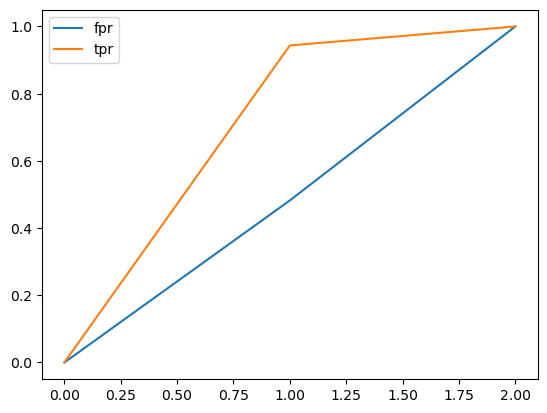

roc auc score =  0.7306461085982933


array([1, 0, 1, ..., 0, 1, 1])

In [61]:
# winning classifier from cross-validation for cutoff 1
clf =  AdaBoostClassifier(n_estimators=175)
scoreClassifier(1, clf, X_train, y_train, X_validate, y_validate)



Based on the analysis of cross-validation data, I picked RandomForest with hyperparameter n_estimators set to 150 to analyze further.

Training 	: #0: 9519  #1: 13832
Predicted 	: #0: 2033  #1: 3805
Actual    	: #0: 2397  #1: 3441
f1 score is  0.8628208666850676
Confusion matrix: 
[[1718  679]
 [ 315 3126]]
Classification report
              precision    recall  f1-score   support

           0       0.85      0.72      0.78      2397
           1       0.82      0.91      0.86      3441

    accuracy                           0.83      5838
   macro avg       0.83      0.81      0.82      5838
weighted avg       0.83      0.83      0.83      5838



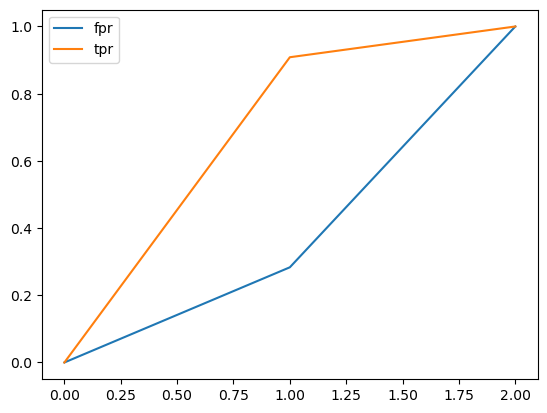

roc auc score =  0.81259304441508


array([0, 0, 1, ..., 0, 1, 1])

In [62]:
# winning classifier from cross-validation for cutoff 2
clf =  RandomForestClassifier(n_estimators=150)
scoreClassifier(2, clf, X_train, y_train, X_validate, y_validate)

Based on the analysis of cross-validation data, I picked Adaboost with hyperparameter n_estimators set to 175 to analyze further.

Training 	: #0: 14213  #1: 9138
Predicted 	: #0: 3636  #1: 2202
Actual    	: #0: 3565  #1: 2273
f1 score is  0.7955307262569832
Confusion matrix: 
[[3143  422]
 [ 493 1780]]
Classification report
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      3565
           1       0.81      0.78      0.80      2273

    accuracy                           0.84      5838
   macro avg       0.84      0.83      0.83      5838
weighted avg       0.84      0.84      0.84      5838



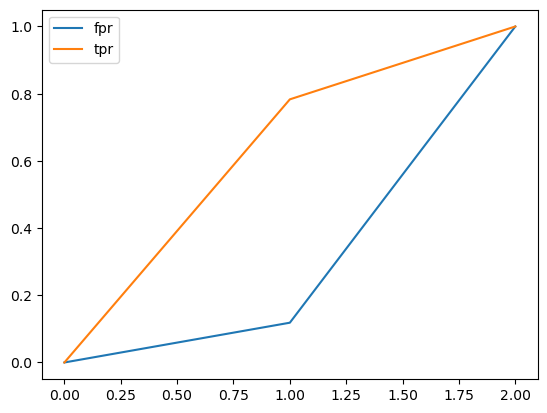

roc auc score =  0.8323664778739875


array([0, 0, 1, ..., 0, 0, 1])

In [64]:
# winning classifier from cross-validation for cutoff 3
clf =  AdaBoostClassifier(n_estimators=175)
scoreClassifier(3, clf, X_train, y_train, X_validate, y_validate)

Based on the cross-validation analysis data, I picked Adaboost with hyperparameter n_estimators set to 125 to analyzer further.

Training 	: #0: 18815  #1: 4536
Predicted 	: #0: 4973  #1: 865
Actual    	: #0: 4732  #1: 1106
f1 score is  0.671740233384069
Confusion matrix: 
[[4529  203]
 [ 444  662]]
Classification report
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      4732
           1       0.77      0.60      0.67      1106

    accuracy                           0.89      5838
   macro avg       0.84      0.78      0.80      5838
weighted avg       0.88      0.89      0.88      5838



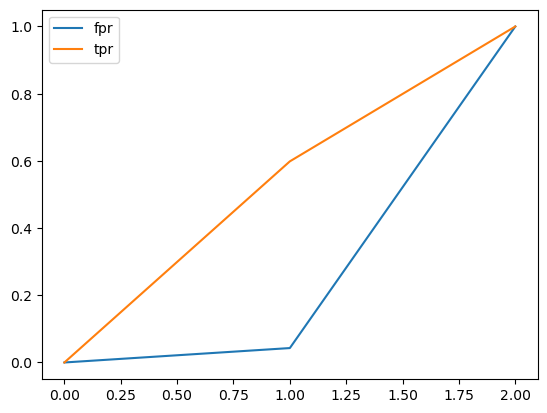

roc auc score =  0.7778269685523824


array([0, 0, 1, ..., 0, 0, 0])

In [65]:
# winning classifier from cross-validation for cutoff 4
clf =  AdaBoostClassifier(n_estimators=125)
scoreClassifier(4, clf, X_train, y_train, X_validate, y_validate)

In [ ]:

genSubmission(1, GaussianNB(), X, y, X_test, 'gaussianNB')
genSubmission(1, MultinomialNB(alpha=0.00001), X, y, X_test, 'multinomialNB')
# genSubmission(1, make_pipeline(StandardScaler(), svm.SVC()), X, y, X_test, 'SVM')
### genSubmission(1, KNeighborsClassifier(n_neighbors=20), X, y, X_test, 'KNN20')
# genSubmission(2, MultinomialNB(alpha=0.0001), X, y, X_test, 'MultinomialNB_alpha_0.0001')
# genSubmission(2, make_pipeline(StandardScaler(), svm.SVC()), X, y, X_test, 'SVM')
# genSubmission(3, MultinomialNB(), X, y, X_test, 'MultinomialNB')
# genSubmission(3, GaussianNB(), X, y, X_test, 'GaussianNB')
# genSubmission(3, LogisticRegression(solver='liblinear', random_state=42, max_iter=1000), X, y, X_test, 'LogisticRegression')
# genSubmission(4, MultinomialNB(), X, y, X_test, 'MultinomialNB')
# genSubmission(4, LogisticRegression(max_iter=1000), X, y, X_test, 'LogisticRegression')


In [35]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=175)
#scoreClassifier(4, clf, X_train, y_train, X_validate, y_validate)
genSubmission(4, clf, X, y, X_test, 'AB175')

Generating submission for:  AB175  with cutoff  4
Training 	: #0: 23547  #1: 5642
Predicted 	: #0: 3755  #1: 745
1: (4500, 1506)  2: 4500
(4500, 2)


In [36]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 175)
#scoreClassifier(4, clf, X_train, y_train, X_validate, y_validate)
genSubmission(4, clf, X, y, X_test, 'RF175')

Generating submission for:  RF175  with cutoff  4
Training 	: #0: 23547  #1: 5642
Predicted 	: #0: 4010  #1: 490
1: (4500, 1506)  2: 4500
(4500, 2)


For the multiclass classification problem, we adapt the infrastructure above to not use the cutoff function. These are the NoCutoff variations. Also, the roc curve does not work for multiclass.

In [78]:
#Utility to train a classifier clf on X_train using y_train, and return predicted values for X_test
def runClassifierNoCutoff(clf, X_train, y_train, X_test):
    ytrc = y_train
    # check labels we are training for
    reportSpread('Training', ytrc)
    clf.fit(X_train, ytrc)
    yp = clf.predict(X_test)
    return yp

# generate a submission for Kaggle upload
def genSubmissionNoCutoff(clf, X_train, y_train, X_test, tag):
    yp = runClassifierNoCutoff(clf, X_train, y_train, X_test)
    # reportSpread('Predicted', yp)
    print('1:', X_test.shape, ' 2:', len(yp))
    ts = pd.DataFrame({'id': range(len(yp)), 'predicted': yp})
    fname = 'kiran_'+tag+'_no_cutoff'+'.csv'
    print(ts.shape)
    ts.to_csv(fname, index=False)


# Utility to train classifier and score it. Returns predicted values for X_test.
def scoreClassifierNoCutoff(clf, X_train, y_train, X_test, y_test):
    yp = runClassifierNoCutoff(clf, X_train, y_train, X_test)
    # reportSpread('Predicted', yp)
    ytec = y_test
    # reportSpread('Actual   ', ytec)
    # f1s = sklearn.metrics.f1_score(ytec, yp)
    # print('f1 score is ', f1s)
    print('Confusion matrix: ')
    print(confusion_matrix(ytec, yp))
    print('Classification report')
    print(classification_report(ytec, yp))
    return yp


# n-fold Cross validation for Hyperparameter tuning using classifier clf
def crossValidateClassifierNoCutoff(n, clf, X_train, y_train):
    ytrc = y_train
    scores = cross_val_score(clf, X_train, ytrc, cv=n)
    return sum(scores)/len(scores)


In [79]:
clf = RandomForestClassifier(n_estimators = 50)
scoreClassifierNoCutoff(clf, X_train, y_train, X_validate, y_validate)
genSubmissionNoCutoff(clf, X, y, X_test, 'RFC50')

Training 	: #0: 0  #1: 4744
Confusion matrix: 
[[806 227  96  40  44]
 [358 516 177  78  55]
 [152 202 572 180  62]
 [ 80 137 209 535 206]
 [ 72  69  55 160 750]]
Classification report
              precision    recall  f1-score   support

           1       0.55      0.66      0.60      1213
           2       0.45      0.44      0.44      1184
           3       0.52      0.49      0.50      1168
           4       0.54      0.46      0.50      1167
           5       0.67      0.68      0.67      1106

    accuracy                           0.54      5838
   macro avg       0.54      0.55      0.54      5838
weighted avg       0.54      0.54      0.54      5838

Training 	: #0: 0  #1: 5957
1: (4500, 1506)  2: 4500
(4500, 2)


CLUSTERING

I combined the review and the summary text for the test data set to use in clustering with the TfidfVectorizer.  My result of 0.63 exceeded the baseline Silhouette score of 0.59. 

In [70]:
# Clustering code

from sklearn import metrics

dftest = pd.read_csv("Test.csv", header=0, encoding='utf-8')

# figure out how many clusters (6)
print(dftest.category.value_counts())

# cvec1 = CountVectorizer(max_features=7500,strip_accents='unicode', stop_words='english')
# cvec1 = HashingVectorizer(n_features=2**4, strip_accents='unicode', stop_words='english')
cvec1 = TfidfVectorizer(max_features=6, stop_words='english', strip_accents='unicode') 
                       # ,token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
                       # , token_pattern=u'(?u)\\b[a-zA-Z\\.][a-zA-Z\\.]+\\b')

dftest['cluster'] = dftest['summary'] + ' ' + dftest['reviewText']
dftest['cluster'] = dftest['cluster'].fillna('')
w = dftest['cluster'].to_list()
cvec1.fit(w)

# clustering
v1 = cvec1.transform(w)
d1 = convertVectorizedText(v1)


# combine data from summary and review text
X_cluster = d1

# figure out how many clusters (6)
# print(dftest.category.value_counts())

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

# km = sklearn.neighbors.NearestNeighbors(n_neighbors=6);

km = KMeans(n_clusters = 6, max_iter=10000, n_init=1, random_state = 0)
# km = MiniBatchKMeans(n_clusters = 12, max_iter=10000, n_init=1, random_state = 0)
# km = KMeans(n_clusters = 6, max_iter=10000, n_init=5, random_state = 0)
# fit_and_evaluate(km, X_cluster, name="km_category")

km.fit(X_cluster)
cluster_ids, cluster_sizes = np.unique(km.labels_, return_counts=True)

print('silhouette score = ', metrics.silhouette_score(X_cluster, km.labels_))

print('clusters_ids=', cluster_ids)

print('cluster-sizes=', cluster_sizes)



automotive     750
CDs            750
grocery        750
cell_phones    750
sports         750
toys           750
Name: category, dtype: int64
silhouette score =  0.6314114305384391
clusters_ids= [0 1 2 3 4 5]
cluster-sizes= [ 516  799 1603  607  469  506]
